## Assignment 2

## Instructions
* This is an individual assignment. You are not allowed to discuss the problems with other students.

* Parts of this assignment will be autograded by gradescope. You can use it as immediate feedback to improve your answers. You can resubmit as many times as you want. Please also note that the **public tests are not exhaustive**, meaning that passing the public tests does not necessarily imply that your implementation is correct. It is recommended to test your implementation in your own ways instead of solely relying on the autograder. 

* All your solution, code, analysis, graphs, explanations should be done in this same notebook.

* Please make sure to execute all the cells before you submit the notebook to the gradescope. You will not get points for the plots if they are not generated already.

* If you have questions regarding the assignment, you can ask for clarifications in Piazza. You should use the corresponding tag for this assignment.

**Warning:** Throughout the assignment, you will be asked to implement certain algorithms. In the solution you submit, do not simply call a library function which performs the entire algorithm for you, this is forbidden, as it would obviously defeat the purpose.  For example, if you were asked to implement the kNN classifier algorithm, do not simply call `sklearn.neighbors.KNeighborsClassifier` on the given data and submit that as your solution. 

**Note 1: The only exceptions to the warning above are _Question 1.2_ and _Question 2.2_ in which you're allowed to the use SciPy's functions.** Relevant hints are given to you at certain stages of the assignment to help you. 


## Context
In this assigment you will be working with the FashionMNIST dataset, and will learn about implementing the following three classifiers and compare their performance on the FashionMNIST dataset.
1. Implement a k-Nearest Neighbour classifier
2. Implement a Gaussian Naive Bayes classifier
3. Implement a Logisitic Regression classifier

The next two cells install and initialize otter-grader. You should run these cells as they are WITHOUT modifying them!

In [1]:
!pip install otter-grader
!git clone https://github.com/chandar-lab/INF8245e-assignments-public.git public

fatal: destination path 'public' already exists and is not an empty directory.


In [2]:
# Initialize Otter
import otter
grader = otter.Notebook(colab=True, tests_dir='./public/assignment_2_python/tests')

The next cells call the necessary libraries for this assignment and contain some helper functions for you to use. 

In [3]:
# Import Packages  
import typing
import numpy as np
import random
import scipy
import matplotlib.pyplot as plt
from typing import Type
%matplotlib inline

from scipy.stats import multivariate_normal

# NOTE: Do NOT change the order of this import call
from keras.datasets import fashion_mnist
# NOTE: Keras has only been used here to import the dataset, you're 
# not allowed to use it anywhere else (we haven't either!)

In [4]:
# Helper Functions

def plot_fashion_mnist(images, labels, n_row=2, n_col=5):
  fig, axes = plt.subplots(n_row, n_col, figsize=(10, 5))
  for i in range(n_row * n_col):
      ax = axes[i//n_col, i%n_col]
      ax.imshow(images[i], cmap='gray')
      ax.set_title('Label: {}'.format(labels[i]))
  plt.tight_layout()
  plt.show()


def plot_accuracies(x, y, title):
  fig = plt.figure(figsize=(10,6))
  plt.plot(x, y, marker='^', label="k")
  plt.title(title)
  plt.xlabel("k-values", fontsize=14)
  plt.ylabel("Test Acc.", fontsize=14)
  plt.legend()
  plt.show()


def iterate_samples(batch_size, sample_set, label_set, shuffle=True):
    # set random seed reproducibility
    np.random.seed(42)
    order = np.arange(sample_set.shape[0])
    if shuffle:
        np.random.shuffle(order)

    # order = np.arange(sample_set.shape[0])
    # if shuffle:
    #     order = np.random.default_rng(42).permutation(sample_set.shape[0])

    for i in range(0, sample_set.shape[0], batch_size):
        batch_samples = sample_set[order[i : i + batch_size]]
        batch_labels = label_set[order[i : i + batch_size]]
        yield batch_samples, batch_labels

### 1. k-Nearest Neighbour Classification (22 points)
 
In this section, we will be looking at the k-nearest neighbours algorithm for classifiying 10 different fashion categores in the Fashion MNIST dataset. In particular, we will learn about the following:

1. Normalizing the input data.
2. Implement a function that classifies FashionMNIST using the kNN algorithm.
3. Perform cross-validation to get the best k.
4. Observe the effect of increasing k to large values.

Fashion MNIST typically acts a drop-in replacement for the well-known MNIST dataset. Its structure is quite similar to MNIST except the labels now represent fashion categories (instead of digits). Here's a table representing each category:

| Label      | Description |
| ----------- | ----------- |
| 0      | T-shirt/Top       |
| 1   | Trouser        |
| 2   | Pullover        |
| 3   | Dress        |
| 4   | Coat        |
| 5   | Sandal        |
| 6   | Shirt        |
| 7   | Sneaker        |
| 8   | Bag        |
| 9   | Ankle Boot        |

It is always important to visualize the data. In the next cell, we load the FashionMNIST dataset and plot 10 images from the training set

Number of images for training: 60000
Number of images for testing: 10000
Size of Fashion MNIST images: (28, 28)


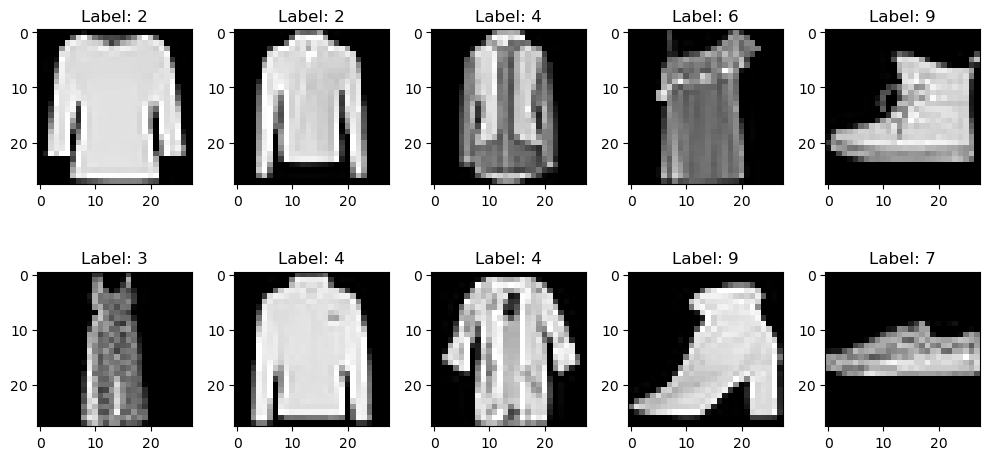

In [5]:
# Load Fashion MNIST data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Shuffle the training set
permuted = np.random.permutation(len(x_train))
x_train, y_train = x_train[permuted], y_train[permuted]

print(f"Number of images for training: {x_train.shape[0]}")
print(f"Number of images for testing: {x_test.shape[0]}")
print(f"Size of Fashion MNIST images: {x_train[0].shape}")

# Visualize 10 images from the training set
plot_fashion_mnist(images=x_train[:10], labels=y_train[:10])

**Question 1.1 (2 points):** Implement a function that performs the min-max normalization.

Min-max normalization (also called feature scaling) performs a linear transformation on the original data such that all values in the range $[0,1]$. Its formula is given by:

\begin{equation}
x_{\textrm{norm}} = \frac{x - x_{\textrm{min}}}{x_{\textrm{max}} - x_{\textrm{min}}}
\end{equation}

In [6]:
def min_max_normalize(data: np.ndarray, min_val=None, max_val=None) -> np.ndarray:
  """
  Normalizes (rescales) the range of features to lie in the range [0, 1].

  Args:
    data: the input data to be normalized (shape: [num_samples x height x width])
    min_val: the minimum value in the dataset. To be set as "None" for normalizing the training data
    max_val: the maximum value in the dataset. To be set as "None" for normalizing the training data
  
  Returns:
    normalized input data (shape: [num_samples x height x width])
    min_val (float): the minimum value in the dataset. 
    max_val (float): the maximum value in the dataset. 
  """

  if min_val is None:
    min_val = np.min(data)
  if max_val is None:
    max_val = np.max(data)
  return (data - min_val) / (max_val - min_val), min_val, max_val
  

In [7]:
grader.check("q1.1")

q1.1 results: All test cases passed!

Now, normalize the training and test data with the function defined above.

In [8]:
# NOTE: Observe how we're normalizing the data. We normalize the training data in the usual manner by 
# calculating the minimum and maximum as given in the formula. However, we cannot do the same for the test 
# data as it is considered a bad practice to tamper with the statistics of the test data. 
# Therefore, we return the min and max values from the training data and use those min/max values for 
# normalizing the test data. 
x_train, min_val, max_val = min_max_normalize(x_train, min_val=None, max_val=None)
x_test, _, _ = min_max_normalize(x_test, min_val, max_val)

# Vectorize the data
n_train, h, w = x_train.shape
n_test, h, w = x_test.shape
x_train_vec, x_test_vec = x_train.reshape(n_train, h*w), x_test.reshape(n_test, h*w)

print(f"Training inputs' shape after vectorization: {x_train_vec.shape}")
print(f"Testing inputs' shape after vectorization: {x_test_vec.shape}")

Training inputs' shape after vectorization: (60000, 784)
Testing inputs' shape after vectorization: (10000, 784)


**Question 1.2 (3 points):** Implement the distance function `get_euclidean_distance`.

In [9]:
def get_euclidean_distance(matrix_a: np.ndarray, matrix_b: np.ndarray) -> np.ndarray:
    """Computes the Euclidean distance between two arrays

    Args:
        matrix_a (np.ndarray): Numpy array of shape [num_samples_a x num_features]
        matrix_b (np.ndarray): Numpy array of shape [num_samples_b x num_features]

    Returns:
        np.ndarray: Numpy array of shape [num_samples_a x num_samples_b] where 
                    each column contains the distance between one element in 
                    matrix_b and all elements in matrix_a
    """
    # NOTE: Depending on your implementation, chances are that you might get out-of-memory errors on Colab. If that is 
    # the case, you are encouraged to think of implementing a more efficient solution using SciPy
    
    # NOTE: This is a more efficient implementation using SciPy
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    
    return scipy.spatial.distance.cdist(matrix_a, matrix_b, metric='euclidean')

In [10]:
grader.check("q1.2")

q1.2 results: All test cases passed!

**Question 1.3 (8 points):** Implement `get_k_nearest_labels` function to the get the labels of the k-nearest neighbours from the training set.

In [11]:
def get_k_nearest_labels(distances: np.ndarray, labels: np.ndarray, k: int) -> np.ndarray:
    """Gets the k nearest labels based on the distances

    Args:
        distances (np.ndarray): Numpy array of shape num_train_samples x num_test_samples 
                                containing the euclidean distances
        labels (np.ndarray): Numpy array of shape [num_train_samples, ] containing 
                                the training labels
        k (int): Int defining the number of nearest neighbours

    Returns:
        np.ndarray: Numpy array of shape [k x num_test_samples] containing the 
                    training labels of the k nearest neighbours for each test sample
    """

    # Sort the distances in ascending and get the indices of the first "k" elements
    # HINT: You need to sort the distances in ascending order to get the indices 
    # of the first "k" elements. BUT, you would not need to sort the entire array, 
    # it would be enough to make sure that the "k"-th element is in the correct position!

    # NOTE: Since the matrix sizes are huge, it would be impractical to run any sort of a 
    # loop to get the nearest labels. Think about how you can do it without using loops.

    return labels[np.argpartition(distances, k, axis=0)[:k]]


In [12]:
grader.check("q1.3")

q1.3 results: All test cases passed!

**Question 1.4 (3 points):** Implement the `get_prediction` function that returns the label class that occurs most frequently.

In [13]:
def get_prediction(nearest_labels: np.ndarray) -> np.ndarray:
    """Gets the best prediction, i.e. the label class that occurs most frequently

    Args:
        nearest_labels (np.ndarray): Numpy array of shape [k x num_test_samples] obtained from the output of the get_k_nearest_labels function

    Returns:
        np.ndarray: Numpy array of shape [1 x num_test_samples] containing the best prediction for each test sample
    """

    prediction = np.zeros((1, nearest_labels.shape[1]))
    for i in range(nearest_labels.shape[1]):
      prediction[0][i] = np.argmax(np.bincount(nearest_labels[:, i]))
    
    return prediction

In [14]:
grader.check("q1.4")

q1.4 results: All test cases passed!

Now, using these functions, we will run the k-NN classifier on a subset of the FashionMNIST dataset! Particularly, we will use 50,000 samples for training, 10,000 samples for validation, and 10,000 samples for testing.

In [15]:
n_train_samples = 50000  
n_val_samples = 10000      
n_test_samples = 10000     

# define the training set and labels
train_set = x_train_vec[:n_train_samples] 
train_labels = y_train[:n_train_samples]
print(f"Training set shape: {train_set.shape}")

# define the validation set and labels
val_set = x_train_vec[-n_val_samples:]
val_labels = y_train[-n_val_samples:]
print(f"Validaton set shape: {val_set.shape}")

# define the test set and labels
test_set = x_test_vec[:n_test_samples]
test_labels = y_test[:n_test_samples]
print(f"Test set shape: {test_set.shape}")

Training set shape: (50000, 784)
Validaton set shape: (10000, 784)
Test set shape: (10000, 784)


In [16]:
def knn_classifier(training_set: np.ndarray, training_labels: np.ndarray, 
                  test_set: np.ndarray, test_labels: np.ndarray, k: int) -> float:
  """
  Performs k-nearest neighbour classification

  Args:
    training_set (np.ndarray): Vectorized training images (shape: [num_train_samples x num_features])
    training_labels (np.ndarray): Training labels (shape: [num_train_samples, 1])
    test_set (np.ndarray): Vectorized test images (shape: [num_test_samples x num_features])
    test_labels (np.ndarray): Test labels (shape: [num_test_samples, 1])
    k (int): number of nearest neighbours

  Returns:
    accuracy (float): the accuracy in % 
  """
  
  dists = get_euclidean_distance(matrix_a=training_set, matrix_b=test_set)
  
  nearest_labels = get_k_nearest_labels(distances=dists, labels=training_labels, k=k)
  
  # from the nearest labels above choose the label classes that occurs most frequently
  predictions = get_prediction(nearest_labels)
  
  # calculate and return accuracy of the predicitions
  accuracy = (np.equal(predictions, test_labels).sum())/len(test_set) * 100.0  

  return accuracy

With the kNN classifier defined, how would you choose the best possible *k* value? We will do some cross validation to get the best _k_. Particularly, we will run the k-NN classifier implemented above on the training the validation sets over **5 values of k**, ranging from 1 to 10 with increments of 2. You are asked to report the k-value which obtains the best validation accuracy. 

And, based on the k-value that obtains the best validation accuracy, run the k-NN classifier again, but this time on the test set. 

In [17]:
# dictionary to store the k values as keys and the validation accuracies as the values
val_accuracy_per_k = {}

# Run the loop with the said increments of k
for k in range(1, 10, 2):
  val_accuracy_per_k[k] = knn_classifier(train_set, train_labels, val_set, val_labels, k)

# print the corresponding k (i.e. the key) for which the accuracy (i.e. the value) is the highest
best_k = max(val_accuracy_per_k, key=val_accuracy_per_k.get) 
print(f"Best validation accuracy of {val_accuracy_per_k[best_k]} % for k={best_k}")


Best validation accuracy of 85.71 % for k=5


<!-- BEGIN QUESTION -->

**Question 1.5 (1 point):** Report the best validation accuracy and the corresponding *k* value that achieves it? (1 sentence)

**Answer 1.5:** k=5 obtains the best validation accuracy of 85.71 %

<!-- END QUESTION -->

#### Reporting the test accuracy and plotting the graphs (3 points)
In this section, you are asked to report the test accuracy and plot a graph with various k-values. You are not required to implement anything here, rather, the points are associated to the test accuracy you will report and the graph obtained.

In [18]:
# Now, based on the best value of k, we run the kNN classifier on the test set.
test_accuracy = knn_classifier(train_set, train_labels, test_set, test_labels, k=best_k)
print(test_accuracy)

85.00999999999999


<!-- BEGIN QUESTION -->

**Question 1.6 (1 point):** Report the test accuracy obtained with the best k-value (1 sentence). 

**Answer 1.6:** The test accuracy with k=5 is 85.01 %.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 1.7 (2 points):** Until now, we have experimented with relatively small values of *k* (within 10). What happens if we increase _k_ to even larger values?
To observe this, we do the following:

1. With the same train/test split, run the k-NN classifer for 4 values of *k* on the test set as given below.

2. Plot the resulting test acccuracies. 

After running the following cell, answer the following question: **Do you observe a trend in the test accuracies?** (in 1 sentence)


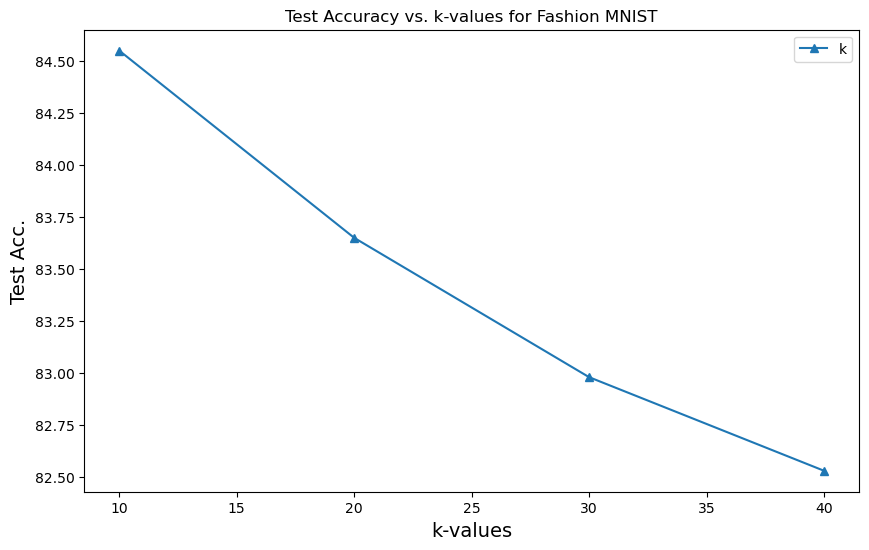

In [19]:
test_accs = []
k_values = [10, 20, 30, 40]

# Run a loop for different k values and store them in the test_accuracies list
for k in k_values:
  test_accs.append(knn_classifier(train_set, train_labels, test_set, test_labels, k=k))

# this function is defined under the helper functions
plot_accuracies(x=k_values, y=test_accs, title="Test Accuracy vs. k-values for Fashion MNIST")

**Answer 1.7:** The trend that I observe is a linear relation between the value of k and the accuracy.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 1.8 (2 points)**: What is the effect on the test accuracy with larger values of *k? Why do you think this is the case? (answer in 3-4 sentences)

**Answer 1.8**: The bigger k is the less accurate is our k-NN classifier. This is the case because for bigger values of k the neighborhood considered is larger and therefore less meaningful. Which leads to less accuracy in our model

<!-- END QUESTION -->

### 2.  Classification using Gaussian Naive Bayes (15 points)

In this section, we will use the Gaussian Naive Bayes (GNB) classifier on the Fashion MNIST dataset. The GNB classifier belongs to the family of probabilistic classifiers based on the application of Bayes' Theorem. The term "naive" in naive Bayes classifiers comes from the fact that they have a strong independence assumptions between the features. In particular, it assumes that the value of a particular feature is independent of the value of another feature, _given the class variable_. 

Consider the training set $ \{( x^{(1)},y^{(1)} ), \ldots, ( x^{(N)},y^{(N)} )) \}$ of N labeled examples, and the input features are $ x^{(i)} \in \mathbb{R}^n$. Since we are interested in multi-class classification, the label $y$ can take K different values i.e. $y^{(i)} \in \{1, 2, \ldots, K\}$. The GNB model assumes that the **class-conditional densities** are distributed according to a multi-variate Gaussian distribution. In other words, the probability of observing the data $x^{(i)}$ given the class variable (also known as, _likelihood_) is given by a Gaussian distribution as shown below:

$$
\begin{equation*}
P (x \mid y=k, \mu_k, \Sigma_k) = \mathcal{N}(x \mid \mu_k, \Sigma_k)
\end{equation*}
$$
where $\mu_k$ denotes the class-specific mean vector and $\Sigma_k$ denotes the class-specific covariance matrix (meaning that each class has its own mean vector and the covariance matrix). Note that since we have a separate covariance matrix for each class $k$, the covariance matrices are not shared among all the classes. 

Given the likelihood of the model, we can now calculate the posterior probability, that is, the probability of a label belonging to a particular class given the data $x^{(i)}$, using Bayes' theorem as follows:

$$
\begin{equation*}
P(y=k \mid x, \mu_k, \Sigma_k) = \frac{P (x \mid y=k, \mu_k, \Sigma_k) P(y=k)}{\sum_{c=1}^K P (x \mid y=c, \mu_c, \Sigma_c) P(y=c)}
\end{equation*}
$$
where $P(y=k)$ denotes the prior probability of a label belonging to a particular class. The denominator is essentially a normalization constant and is not technically required to be implemented. Observe that it this likelihood $P (x \mid y=k, \mu_k, \Sigma_k)$ that is distributed according to a multi-variate Gaussian distribution given below:

$$
\begin{equation*}
P (x \mid y=k, \mu_k, \Sigma_k) = \frac{1}{(2 \pi)^{K/2} | \Sigma_k |^{1/2} } \exp \left( -\frac{1}{2} (x - \mu_k)^{T} \Sigma_k^{-1} (x - \mu_k) \right)
\end{equation*}
$$
where $| \Sigma_k |$ denotes the determinant of the covariance matrix, and $K$ denotes the number of classes. An important note here is that the probabilities are small and in the case of high dimensionality they tend to be very close to zero and result in numerical underflow issues. Therefore, we will be considering the _log_ of the likelihood function instead. Hence, the resulting log-likelihood can be written as:

$$
\begin{equation*}
\log P (x \mid y=k, \mu_k, \Sigma_k) = - \frac{K}{2} \log(2 \pi) - \frac{1}{2} \log(| \Sigma_k |) - \frac{1}{2} (x - \mu_k)^{T} \Sigma_k^{-1} (x - \mu_k)
\end{equation*}
$$

Likewise, the log-posterior can be written as:
$$
\begin{equation*}
\log P(y=k \mid x, \mu_k, \Sigma_k) \propto \log P (x \mid y=k, \mu_k, \Sigma_k) + \log P(y=k) - \log (\textrm{const.})
\end{equation*}
$$
Note that we have used the $\propto$ symbol above which indicates that the log of the posterior probability density for a class can be computed as the sum of the log-likelihood and the log prior probability densities, _upto_ the log of the normalization constant. 

Now, given the theory, there are two implementation questions in this section. In the first, you are asked to compute the class-specific mean and covariance vectors and the prior probabilities for each class. In the second question, you are required to use these 3 quantities to calculate the posterior probability of each class given the data. While the math and notations given above maybe a bit overwhelming, you are not required to implement the multi-variate Gaussian function. You can use SciPy's function for the same, more details are given in the question. 


**Question 2.1 (6 points):** Complete the `gnb_fit_classifier` function that fits the GNB classifier on the training data.

In [20]:
def gnb_fit_classifier(X: np.ndarray, Y: np.ndarray, smoothing: float=1e-3) -> typing.Tuple:
    """Fits the GNB classifier on the training data

    Args:
        X (np.ndarray): numpy array of shape [num_samples x num_features] containing the vectorized training data
        Y (np.ndarray): numpy array of shape [num_samples, ] containing the training labels
        smoothing (float, optional): constant to avoid division by zero. Defaults to 1e-3.

    Returns:
        prior_probs (typing.List[float]): list of length `num_classes` containing the prior probabilities of the training labels
        means (typing.List[np.ndarray]): list of length `num_classes` containing the means of the batch of samples belonging to a particular label
                                            shape of each element in the list - (num_features, )
        vars (typing.List[np.ndarray]): list o f length `num_classes` containing the variances of the batch of samples belonging to a particular label
                                            shape of each element in the list - (num_features, )
    """

    # to set the prior probability of each label by counting the number of times the label appears in 
    # training data and normalizing it by the total number of training samples.
    prior_probs = []
    
    means, vars = [], []

    labels = np.unique(Y)
    num_classes = len(labels)

    for label in labels:
        # get the indices of the samples that belong to the current label
        indices = np.where(Y == label)[0]
        # get the samples that belong to the current label
        samples = X[indices]
        # get the prior probability of the current label
        prior_probs.append(len(indices)/len(Y))
        # get the mean of the current label
        means.append(np.mean(samples, axis=0))
        # get the variance of the current label
        vars.append(np.var(samples, axis=0) + smoothing)
    
    return prior_probs, means, vars

In [21]:
grader.check("q2.1")

q2.1 results: All test cases passed!

**Question 2.2 (6 points):** Complete the `gnb_predict` function to get the predictions from the classifier.

In [22]:
def gnb_predict(X: np.ndarray, prior_probs: typing.List[np.ndarray], 
                    means: typing.List[np.ndarray], vars: typing.List[np.ndarray], num_classes: int) -> np.ndarray:
    """Computes the predictions of all test samples from the GNB classifier

    Args:
        X (np.ndarray): numpy array of shape [num_samples x features] containing vectorized test images
        prior_probs (typing.List[float]): list of length `num_classes` containing the prior probabilities of the training labels
        means (typing.List[np.ndarray]): list of length `num_classes` containing the means of the batch of samples belonging to a particular label
        vars (typing.List[np.ndarray]): list of length `num_classes` containing the variances of the batch of samples belonging to a particular label
        num_classes (int): int defining the number of classes

    Returns:
        np.ndarray: numpy array of shape (num_samples) containing predictions for each test sample
    """

    num_samples, feature_dim = X.shape

    all_preds = np.zeros((num_samples,  num_classes))

    # HINT: Check out SciPy's multivariate normal documentation and 
    # think about which function to use to prevent underflow issues

    for i in range(num_classes):
        all_preds[:, i] = prior_probs[i] * multivariate_normal.pdf(X, mean=means[i], cov=vars[i])

    # for each prediction in `all_preds`, get the label the label that occurs most frequently
    preds = np.argmax(all_preds, axis=1)

    return preds

In [23]:
grader.check("q2.2")

q2.2 results: All test cases passed!

Now using the functions above let us test the GNB classifer!

In [24]:
def gnb_classifier(train_set, train_labels, test_set, test_labels, smoothing=1e-3):

  num_classes = len(np.unique(y_train))

  prior_probs, means, vars = gnb_fit_classifier(train_set, train_labels, smoothing=1e-3)

  preds = gnb_predict(test_set, prior_probs, means, vars, num_classes)

  accuracy = np.mean(np.equal(preds, test_labels)) * 100.0

  return accuracy

In [25]:
# Run again to make sure that the inputs remain the same.

# define the training set and labels
train_set = x_train_vec[:n_train_samples]
train_labels = y_train[:n_train_samples]
print(f"Training set shape: {train_set.shape}")

# define the validation set and labels
val_set = x_train_vec[-n_val_samples:]
val_labels = y_train[-n_val_samples:]
print(f"Validaton set shape: {val_set.shape}")

# define the test set and labels
test_set = x_test_vec[:n_test_samples]
test_labels = y_test[:n_test_samples]
print(f"Test set shape: {test_set.shape}")

Training set shape: (50000, 784)
Validaton set shape: (10000, 784)
Test set shape: (10000, 784)


<!-- BEGIN QUESTION -->

**Question 2.3 (1 point):** Report the test accuracy obtained by the GNB classifier. (1 sentence)

In [26]:
# test the model!
test_acc = gnb_classifier(train_set, train_labels, test_set, test_labels)
print(f"Test accuracy: {test_acc} %")

/Users/sanmarsimon/opt/anaconda3/envs/INF8245E/lib/python3.10/site-packages/scipy/stats/_multivariate.py:517: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, mean, psd.U, psd.log_pdet, psd.rank))


Test accuracy: 65.72 %


**Answer 2.3:** The test accuracy obtained by the GNB classifier is 65.72 %.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2.4 (2 points):** Compare the test accuracies between the GNB classfier and the k-NN classifier. What do you observe? Which classifier is a better choice? Justify your answer in 3-4 sentences. 

**Answer 2.4**: The k-NN classifier has a much better accuracy than the GNB classifier. This can be explained by the strong assumptions that GNB is making that features are independant which is clearly not the case here with image's pixel.

<!-- END QUESTION -->

### 3.  Classification using Logistic Regression (42 points)

In this section, you will be using logistic regression for classifying different categories on the same FashionMNIST dataset. In particular, the following are the objectives for this section:

1. Understanding logistic regression for multi-class classification problems.
2. Learning to derive the gradient of the softmax function and implement the `softmax` function.
3. Implementing the gradient updates in the function `compute_gradient`.
4. Understanding and implementing the training and validation phases in a standard machine learning training regime. 
5. Explore the effects of different hyperparameters on the logistic regression model. 


Consider a logistic regression model for classifying the FashionMNIST categories, where we have a training set $ \{( x^{(1)},y^{(1)} ), \ldots, ( x^{(N)},y^{(N)} )) \}$ of N labeled examples, and the input features are $ x^{(i)} \in \mathbb{R}^n$. Since we are interested in multi-class classification, the label $y$ can take K different values i.e. $y^{(i)} \in \{1, 2, \ldots, K\}$. Note that for ease of notation, we start the index of classes from 1, rather than from 0.

Now, given a test input $x^{(i)}$, we want our hypothesis to estimate the probability that $P(y=k | x^{(i)})$ for each value of $ k = 1, \ldots , K $, i.e. we want to estimate the probability of the class label taking on each of the K
different possible values. Thus, our hypothesis will output a $K - $
dimensional vector (whose elements sum to 1) giving us our $K$ estimated probabilities. Concretely, the hypothesis function (denoted by $z$) for a single input $x^{(i)}$ takes the following form:

\begin{align*}
    z_{(w, b)}(x^{(i)}) &= 
        \begin{bmatrix}
           P(y=1 \mid x^{(i)}; w, b) \\
           P(y=2 \mid x^{(i)}; w, b) \\
           \vdots \\
           P(y=K \mid x^{(i)}; w, b)
         \end{bmatrix} 
          &= \frac{1}{\sum_{j=1}^K \exp(h^{(i)}_j)}  
          \begin{bmatrix}
           \exp(h^{(i)}_1) \\
           \exp(h^{(i)}_2) \\
           \vdots \\
           \exp(h^{(i)}_K))
         \end{bmatrix} 
  \end{align*}, 

where $h^{(i)} = w^T x^{(i)} + b$ containing the parameters of the model. Particularly,  $w \in \mathbb{R}^{K \times n}$ denotes the weight matrix, $b \in \mathbb{R}^K$ is the bias vector associated with each of the classes. Lastly, notice in the hypothesis function that we have a term of the form $\frac{\exp(⋅)}{\sum_j \exp(⋅)}$, this is called the softmax function and is used frequently in machine learning for multi-class classification problems since it outputs values as probabilities between 0 and 1. 


We will use the negative log-likelihood loss for training our logistic regression model. As the name suggests, it simply calculates the negative of the log likelihood of the model and is given by: 

\begin{equation}
L = - \frac{1}{N} \sum_{i=1}^N \log \hat{y}^{(i)} = - \frac{1}{N} \sum_{i=1}^N \log \left( \frac{ e^{h^{(i)}_y} }{ \sum_{j=1}^K e^{h^{(i)}_j} } \right) 
\end{equation}

<!-- BEGIN QUESTION -->

**Question 3.1 (10 points)**

Now that we have defined our model and the loss function, calculate the derivative of the loss function $L$ w.r.t the weight matrix $w$ and the bias vector $b$. In other words, get the gradient update expressions for $w$ i.e. $\frac{\partial L}{\partial w}$ and $b$ i.e. $\frac{\partial L}{\partial b}$. 

**Hints**: 

1. It might be good to start by calculating the derivative of the softmax function
2. Think about how you can get the derivative of a particular quantity when it is inside a summation. Is there a way to divide the term into sub-terms and then computing the individual gradients?


**Answer 3.1**

NOTE: $\hat{y}^{(i)}$ is the model's prediction for the target label for the $i^{(th)}$ observation

$$
\begin{aligned}
\hat{y}^{(i)} = \textrm{softmax}(h^{(i)})\\
\textrm{softmax}(h^{(i)}) = \frac{\exp(h^{(i)})}{ \sum_{j} \exp{(h^{(j)})}}
\end{aligned}
$$

Where $$h^{(i)} = w^T x^{(i)} + b$$

Using Chain derivatives we have for both $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$

$$
\begin{aligned}
\frac{\partial L}{\partial w} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial h} \frac{\partial h}{\partial w}\\
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial h} \frac{\partial h}{\partial b}\\
\end{aligned}
$$

Now if we consider loss for a single observation we get : (Where $L^{(i)} = - \log \hat{y}^{(i)}$)

$$
\begin{aligned}
\frac{\partial L^{(i)}}{\partial w} = \frac{\partial L^{(i)}}{\partial \hat{y}^{(i)}} \frac{\partial \hat{y}^{(i)}}{\partial h^{(i)}} \frac{\partial h^{(i)}}{\partial w}\\
\frac{\partial L^{(i)}}{\partial b} = \frac{\partial L^{(i)}}{\partial \hat{y}^{(i)}} \frac{\partial \hat{y}^{(i)}}{\partial h^{(i)}} \frac{\partial h^{(i)}}{\partial b}\\
\end{aligned}
$$

So this will give us
$$
\begin{aligned}
\frac{\partial L}{\partial w} = -\frac{1}{N} \sum_{i=1}^N \frac{\partial L^{(i)}}{\partial w}\\
\frac{\partial L}{\partial b} = -\frac{1}{N} \sum_{i=1}^N \frac{\partial L^{(i)}}{\partial b}\\
\end{aligned}
$$

So : 

$$
\begin{aligned}
\frac{\partial L^{(i)}}{\partial \hat{y}^{(i)}} = -\frac{1}{\hat{y}^{(i)}} \tag{1}\\ 
\end{aligned}
$$
$$
\begin{aligned}
\frac{\partial \hat{y}^{(i)}}{\partial h^{(i)}} = \hat{y}^{(i)} (1-\hat{y}^{(i)}) \tag{2}\\
\end{aligned}
$$
$$
\begin{aligned}
\frac{\partial h^{(i)}}{\partial w} = x^{(i)} \tag{3}\\
\end{aligned}
$$
$$
\begin{aligned}
\frac{\partial h^{(i)}}{\partial b} = 1 \tag{4}\\
\end{aligned}
$$

Combining (1), (2) and (3) we find that: (NOTE: $y^{(i)}$ = 1 for the target label, 0 otherwise for the $i^{(th)}$ observation)

$$
\begin{aligned}
\frac{\partial L}{\partial w} = -\frac{1}{N} \sum_{i=1}^N (y^{(i)} - \hat{y}^{(i)})x^{(i)}\\
\end{aligned}
$$

Combining (1), (2) and (4) we find that:

$$
\begin{aligned}
\frac{\partial L}{\partial b} = -\frac{1}{N} \sum_{i=1}^N (y^{(i)} - \hat{y}^{(i)})\\
\end{aligned}
$$

<!-- END QUESTION -->

With all the theory in place, we will now implement individual functions at bring them all together at the end to train your logistic your logistic regression model!

**Question 3.2 (2 Points)**
Implement the `softmax` function below. As we have seen in the introduction, the softmax function is given by:

\begin{equation*}
\textrm{softmax}(x) = \frac{\exp(x)}{ \sum_{j} \exp{(x_j)}}
\end{equation*}

In [27]:
def softmax(x: np.ndarray) -> np.ndarray:
    """
    Takes the input and applies the softmax function to it
    
    Args:
        x: Numpy array of shape []
    
    Returns:
        np.ndarray: the softmax-ed input
    """
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

In [28]:
grader.check("q3.2")

q3.2 results: All test cases passed!

**Question 3.3 (3 points)**
A skeleton of the logistic regression model is given to you in the `LogisticRegressionModel` class. Implement the `__call__` function that essentially computes the output probability given the batch of inputs. 

In [29]:
class LogisticRegressionModel:
    def __init__(self, init_weights: np.ndarray) -> None:
        num_classes = init_weights.shape[0]
        # the weight matrix. Shape = [num_classes x num_features]
        self.W = np.copy(init_weights)
        # the bias vector. Shape = [num_classes]
        self.b = np.zeros((num_classes))

    def __call__(self, x: np.ndarray) -> np.ndarray :
        """
        Computes the hypothesis function, i.e. the prediction (y_hat) of the logistic regression model        
        
        Args:
            x: Numpy array of shape [batch_size x num_features] containing input mini-batch of samples
        
        Returns:
            x: Numpy array of shape (shape: [batch_size x num_classes]) containing the output class probabilities 
                after applying the softmax function
        """
        # HINT: Look into the documentation of np.matmul
        
        return softmax(x @ self.W.T + self.b)



In [30]:
grader.check("q3.3")

q3.3 results: All test cases passed!

**Question 3.4 (3 points)**
Implement the `negative_log_likelihood` loss function given the predictions and the target labels as defined in the introduction of this section. To recap, the equation for negative log likelihood is given by:
\begin{equation}
L = - \frac{1}{N} \sum_{i=1}^N \log \hat{y}^{(i)} 
\end{equation}

In [31]:
def negative_log_likelihood(prediction: np.ndarray, target: np.ndarray) -> float:
    """
    Computes the negative log likelihood loss between the prediction and the target
    
    Args:
        prediction: Numpy array of shape [batch size x num_classes]
        target: Numpy array of shape  [batch size, ]
    
    Returns:
       (float): the negative log likelihood loss 
    """
    
    batch_size = prediction.shape[0]

    return -np.sum(np.log(prediction[np.arange(batch_size), target])) / batch_size

In [32]:
grader.check("q3.4")

q3.4 results: All test cases passed!

**Question 3.5 (6 points)**
Using the gradient update expressions that you have derived in Question 3.1, implement the `compute_gradients` function below. 

In [33]:
def compute_gradients(x: np.ndarray, prediction: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Computes the gradient of the loss function w.r.t the parameters
    
    Args:
        x (np.ndarray): Numpy array of shape [batch size x num_features]
        prediction (np.ndarray): Numpy array of shape [batch size x num_classes]
        target (np.ndarray): Numpy array of shape  [batch size, ]
    
    Returns:
        grad_W (np.ndarray): Numpy array of shape [num_classes x num_features] 
                             i.e. same as the weights matrix
        grad_b (np.ndarray): Numpy array of shape [num_classes, ]
    """

    # HINT: Look into the documentation of np.eye

    # create a one-hot encoded matrix of shape [batch_size x num_classes]
    one_hot = np.eye(prediction.shape[1])[target]

    # compute the gradient of the loss w.r.t the weights
    grad_W = -np.matmul((one_hot - prediction).T, x) / x.shape[0]

    # compute the gradient of the loss w.r.t the bias
    grad_b = -np.sum(one_hot - prediction, axis=0) / x.shape[0]

    return grad_W, grad_b

In [34]:
grader.check("q3.5")

q3.5 results: All test cases passed!

**Question 3.6 (6 points)**
Validation is one of the most important phases in training machine learning models. This is done so as to evaluate the learning capability of the model by testing it on the samples from the validation set. The procedure is as follows: Given the model and the batch size, iterate through the validation set to compute the loss and accuracy of the model. Note that in the validation phase, we do not compute the gradients.  
Now, Implement the `validation` function below.

In [35]:
def validation(model: Type[LogisticRegressionModel], val_set: np.ndarray, val_labels: np.ndarray, 
                batch_size: int) -> float:
    """
    Performs validation of the given input model
    
    Args:
        model (type: class): the model to be validated
        val_set (np.ndarray): Numpy array of shape [val_size x num_features]
        val_laels (np.ndarray): Numpy array of shape [val_size]
        batch_size (int): Int defining the batch_size
    
    Returns:
        val_loss (float): the validation loss for the entire validation set
        val_acc (float): the validation accuracy for the entire validation set
    """

    total_loss = 0.0
    correct_preds = 0
    sample_count = 0
    batch_count = 0
    
    for batch, labels in iterate_samples(batch_size, val_set, val_labels, False):
        batch_count += 1
        sample_count += batch.shape[0]
        prediction = model(batch)
        total_loss += negative_log_likelihood(prediction, labels)
        correct_preds += np.sum(np.equal(np.argmax(prediction, axis=1), labels))

    validation_loss = total_loss / batch_count
    validation_acc = correct_preds / sample_count
    
    return validation_loss, validation_acc

In [36]:
grader.check("q3.6")

q3.6 results: All test cases passed!

**Question 3.7 (10 points)**
Lastly, implement the `train_one_epoch` function below. This function uses combines the functions that you have already implemented above, namely, the `LogisticRegressionModel` class, the `negative_log_likelihood`, `compute_gradients`, and the `validation` functions. This function returns all the necessary outputs required for plotting the training and validation curves as shall be seen below.

In [37]:
def train_one_epoch(model: Type[LogisticRegressionModel],
                    train_set: np.ndarray, train_labels: np.ndarray, 
                    val_set: np.ndarray, val_labels:np.ndarray,
                    batch_size: int, learning_rate: float, 
                    validation_every_x_step: int) -> float:
    """
    Trains the model for one epoch on the entire dataset with the given learning rate and batch size
    
    Args:
        model (class): the model used to train
        train_set (np.ndarray): Numpy array of shape [val_size x num_features]
        train_laels (np.ndarray): Numpy array of shape [val_size]
        val_set (np.ndarray): Numpy array of shape [val_size x num_features]
        val_laels (np.ndarray): Numpy array of shape [val_size]
        batch_size (int): the batch size to be used to iterate through the dataset
        learning_rate (float): the learning rate to be used for mini-batch gradient descent optimization
        validation_every_x_step (int): the number of steps to wait before performing validation
    
    Returns:
        train_losses (list): a list of training losses
        train_accuracies (list): a list of training accuracies
        # train_steps (list): a list of the training batch ids, i.e. each element is the n-th batch of the training set
        train_steps (list): a list of the number of training steps. One training step is defined as one forward pass 
                            (i.e. calculating the loss) AND one backward pass (i.e. calculating the gradients and updating the parameters) 
                            of a mini-batch of samples through the model
        val_losses (list): a list of validation losses
        val_accuracies (list): a list of validation accuracies
        val_steps (list): a list of the validation steps. One validation step is defined one forward pass of the validaton mini-batch
                            samples through the model
    """
    train_losses = []
    train_accuracies = []
    train_steps = []
    val_losses = []
    val_accuracies = []
    val_steps = []
    step_count = 0

    # Iterate through the training set and append the corresponding metrics to the list
    for x_batch, targets in iterate_samples(batch_size, train_set, train_labels, True):
        step_count += 1
        prediction = model(x_batch)
        train_loss = negative_log_likelihood(prediction, targets)
        train_losses.append(train_loss)
        training_accuracy = np.sum(np.equal(np.argmax(prediction, axis=1), targets)) / batch_size
        train_accuracies.append(training_accuracy)
        train_steps.append(step_count)
        grad_W, grad_b = compute_gradients(x_batch, prediction, targets)
        model.W = model.W - learning_rate * grad_W
        model.b = model.b - learning_rate * grad_b


        # perform validation depending on the value of `validation_every_x_step`
        if (step_count % validation_every_x_step) == 0 or step_count == 1:
            val_loss, val_acc = validation(model, val_set, val_labels, batch_size)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            val_steps.append(step_count)
        
    return train_losses, train_accuracies, train_steps, val_losses, val_accuracies, val_steps



In [38]:
grader.check("q3.7")

q3.7 results: All test cases passed!

#### Bringing it all together

Using all the functions you have implemented above, you will now train a logistic regression model on the Fashion MNIST dataset!

In [39]:
def train_model(num_epochs: int, batch_size: int, learning_rate: float, validation_every_x_step: int, W_initial_weights: float) -> float:
    """
    Trains the logistic regression model

    Args:
        num_epochs (int): Number of epochs to train the model for
        batch_size (int): Size of the mini-batch
        learning_rate (float): Step size for mini-batch gradient descent optimization
        validation_every_x_step (int): Perform validation at every x-th step
        W_initial_weights (float): Randomly initialized weight matrix

    Returns:
        train_loss: list containing training losses at each epoch
        train_accuracy: list containing training accuracies at each epoch
        train_step: 
        val_loss: list containing validation losses at each epoch
        val_accuracy: list containing validation accuracies at each epoch
        val_step:
    """

    train_loss = []
    train_accuracy = []
    train_step = []
    val_loss = []
    val_accuracy = []
    val_step = []
    epoch_last_step = 0
    
    model = LogisticRegressionModel(W_initial_weights)
    
    for i in range(num_epochs):
        epoch_train_loss, epoch_train_accuracy, epoch_train_step, \
             epoch_val_loss, epoch_val_accuracy, epoch_val_step = \
                train_one_epoch(model, train_set, train_labels, val_set, 
                    val_labels, batch_size, learning_rate, 
                    validation_every_x_step)

        train_loss += epoch_train_loss
        train_accuracy += epoch_train_accuracy
        train_step += [step + epoch_last_step for step in epoch_train_step]

        val_loss += epoch_val_loss
        val_accuracy += epoch_val_accuracy
        val_step += [step + epoch_last_step for step in epoch_val_step]

        epoch_last_step = train_step[-1]
        
    return train_loss, train_accuracy, train_step, val_loss, val_accuracy, val_step

In [40]:
# initiliaze weights from a normal distribution
W_initial_weights = np.random.normal(0.5, 0.1, (10, 784))

# train a logistic regression model
train_loss_bs100, train_accuracy_bs100, train_step_bs100, val_loss_bs100, \
    val_accuracy_bs100, val_step_bs100 = \
        train_model(num_epochs=4, batch_size=100, learning_rate=0.1, 
        validation_every_x_step=10, W_initial_weights=W_initial_weights)

<!-- BEGIN QUESTION -->

**Question 3.8 (2 points):** As in the previous section, you are asked to plot the training and validation accuracy curves (points are associated to the type of the curves you report).

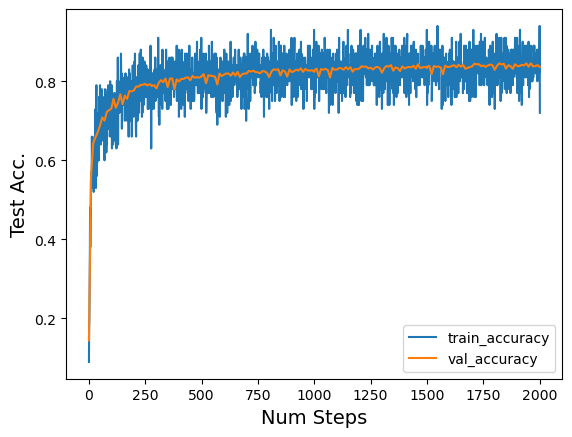

In [41]:
fig = plt.figure()
plt.plot(train_step_bs100, train_accuracy_bs100, label='train_accuracy')
plt.plot(val_step_bs100, val_accuracy_bs100, label='val_accuracy')
plt.xlabel("Num Steps", fontsize=14)
plt.ylabel("Test Acc.", fontsize=14)
plt.legend()
plt.show()

<!-- END QUESTION -->

### 4. Comparing kNN, GNB and Logistic Regression Classifiers (3 points)

Nice work! Now that your logistic regression classifier works, we will compare the performance of these 3 classifiers together. 

We will be using a batch size of 100 and a learning rate of 0.1 to evaluate the logistic regression classifier on the test set. Ideally, extensive hyperparamter tuning must be done on the validation set to choose the best possible hyperparameter configurations for your classifier. However, one of your objectives in the next assignment will be hyperparameter tuning, hence we are giving you the best hyperparameters in this assignment!

In [42]:
# RUN THIS CELL TO DEFINE THE FUNCTION FOR TESTING THE MODEL 
# NOTE: IT IS VERY SIMILAR TO `train_model` THAT YOU HAVE ALREADY IMPLEMENTED EXCEPT, THE 'VALIDATION' PARTS ARE CHANGED TO 'TEST'

def test_model(num_epochs: int, batch_size: int, learning_rate: float, validation_every_x_step: int, W_initial_weights: float) -> float:
    """
    Trains the logistic regression model

    Args:
        num_epochs (int): Number of epochs to train the model for
        batch_size (int): Size of the mini-batch
        learning_rate (float): Step size for mini-batch gradient descent optimization
        validation_every_x_step (int): Perform validation at every x-th step
        W_initial_weights (float): Randomly initialized weight matrix

    Returns:
        train_loss: list containing training losses at each epoch
        train_accuracy: list containing training accuracies at each epoch
        train_step: 
        test_loss: list containing test losses at each epoch
        test_accuracy: list containing test accuracies at each epoch
        test_step:
    """

    train_loss = []
    train_accuracy = []
    train_step = []
    test_loss = []
    test_accuracy = []
    test_step = []
    epoch_last_step = 0
    
    model = LogisticRegressionModel(W_initial_weights)
    
    # note here that we have just replaced the validation set with the test set, 
    # the rest of the procedure remains the same
    for i in range(num_epochs):
        epoch_train_loss, epoch_train_accuracy, epoch_train_step, \
             epoch_test_loss, epoch_test_accuracy, epoch_test_step = \
                train_one_epoch(model, train_set, train_labels, test_set, 
                    test_labels, batch_size, learning_rate, 
                    validation_every_x_step)

        train_loss += epoch_train_loss
        train_accuracy += epoch_train_accuracy
        train_step += [step + epoch_last_step for step in epoch_train_step]

        test_loss += epoch_test_loss
        test_accuracy += epoch_test_accuracy
        test_step += [step + epoch_last_step for step in epoch_test_step]

        epoch_last_step = train_step[-1]
        
    return train_loss, train_accuracy, train_step, test_loss, test_accuracy, test_step

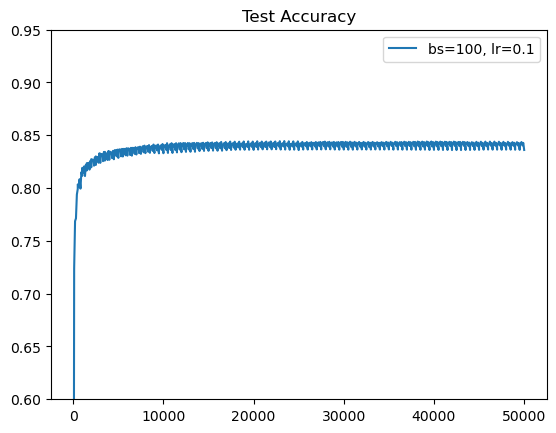

Best test accuracy: 83.61 %


In [43]:
best_batch_size = 100
best_lr = 0.1

# Test the model!
_ , _ , _ , \
     test_loss, test_accuracy, test_step = test_model(num_epochs=100, batch_size=best_batch_size, 
                                                        learning_rate=best_lr, validation_every_x_step=100, W_initial_weights=W_initial_weights)

fig = plt.figure()
plt.plot(test_step, test_accuracy, label=f"bs={best_batch_size}, lr={best_lr}")
plt.title('Test Accuracy')
plt.ylim(0.6, 0.95)
plt.legend()
plt.show()

print(f"Best test accuracy: {test_accuracy[-1] * 100.0} %")

<!-- BEGIN QUESTION -->

**Question 4.1:** Report the test accuracies obtained using all the three classifiers. Which model performs the best? Why do you think this is the case? (Justify in 3-4 sentences)

**Answer 4.1:** 
kNN accuracy = 85.01 %, GNB accuracy = 65.72 %, and Logistic regression accuracy = 83.61 % (with batch_size = 100 lr = 0.1

Out of the three, kNN classifier performs the best. 

This is because kNN is the model that makes the more sense in this application. GNB is not really pertinent here since this model is based on assuming that features are independent which is far from being true when it comes to two consecutive pixel of an image. The logistic regression model is slightly less accurate than kNN this might be because it only support linear decision boundary

<!-- END QUESTION -->

